<a href="https://colab.research.google.com/github/RicoStaedeli/NLP2025_CQG/blob/main/5_Evaluation_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import userdata
import os

In [8]:
token = userdata.get('GITHUB')
repo_url = f"https://{token}@github.com/RicoStaedeli/NLP2025_CQG.git"

!git clone {repo_url}


os.chdir("NLP2025_CQG")
!ls

Cloning into 'NLP2025_CQG'...
remote: Enumerating objects: 794, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 794 (delta 47), reused 35 (delta 35), pack-reused 737 (from 2)
Receiving objects: 100% (794/794), 25.15 MiB | 11.32 MiB/s, done.
Resolving deltas: 100% (399/399), done.
1_Information_preprocessing.md	      Development
1_Preprocessing.ipynb		      Doc
2_Baseline_Generation.ipynb	      Evaluation
2_Information_Baseline_Generation.md  INFORMATION.md
3a_Finetuned_CQS_generation.ipynb     LICENSE
3b_Finetune_Evaluation.ipynb	      Logs
3_Evaluation.ipynb		      README.md
4_Finetuned_Generation.ipynb	      requirements.txt
5_Evaluation_Analytics.ipynb	      Training
Data				      Utils


In [9]:
import json

result_file = "results_schema_Baseline_Meta-Llama-3.1-8B-Instruct-bnb-4bit"

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{result_file}_eval.json"), "r", encoding="utf-8") as f:
    data = json.load(f)

In [10]:
import pandas as pd

df_list = []
for key, val in data.items():
    for cq in val['cqs']:
        df_list.append({
            'id': key,
            'input': val['input'],
            'schema': cq['schema'],
            'question': cq['cq'],
            'score': cq['score'],
            'is_critical': cq['is_critical']
        })

df = pd.DataFrame(df_list)
df.head()

,id,input,schema,question,score,is_critical
0,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",CauseToEffect,Are there other factors in this particular cas...,3.0,False
1,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",ExpertOpinion,Is Clinton's claim that working with NATO and ...,5.5,False
2,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",Analogy,Are there differences between the approach of ...,7.0,True
3,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",FearAppeal,Is it not a contradictory approach for Clinton...,2.0,False
4,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",CauseToEffect,Are there other factors in this particular cas...,3.0,False


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

print("Score stats by is_critical:")
print(df.groupby('is_critical')['score'].describe())

Score stats by is_critical:
             count      mean       std  min  25%  50%  75%   max
is_critical                                                     
False        513.0  3.602339  1.784743  0.0  2.0  3.0  5.0   6.5
True         231.0  8.086580  1.144492  7.0  7.0  7.5  9.0  10.5


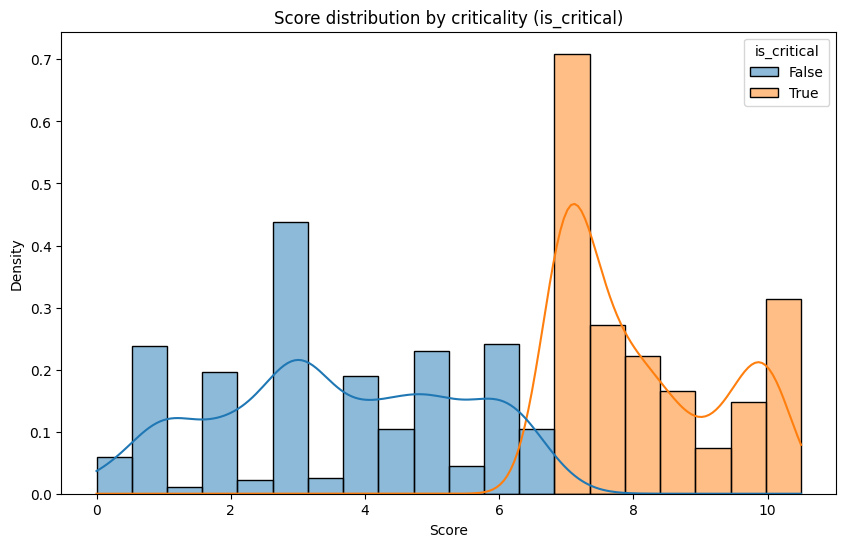

In [21]:

# Visualize score distributions
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='score', hue='is_critical', bins=20, kde=True, stat='density', common_norm=False)
plt.title('Score distribution by criticality (is_critical)')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

In [16]:
agg_true = df.groupby(['id', 'schema'])['is_critical'].max().reset_index()

summary = agg_true.groupby(['schema', 'is_critical']).size().unstack(fill_value=0)
print(summary)

is_critical    False  True 
schema                     
Analogy           41    145
CauseToEffect    170     16
ExpertOpinion    130     56
FearAppeal       172     14


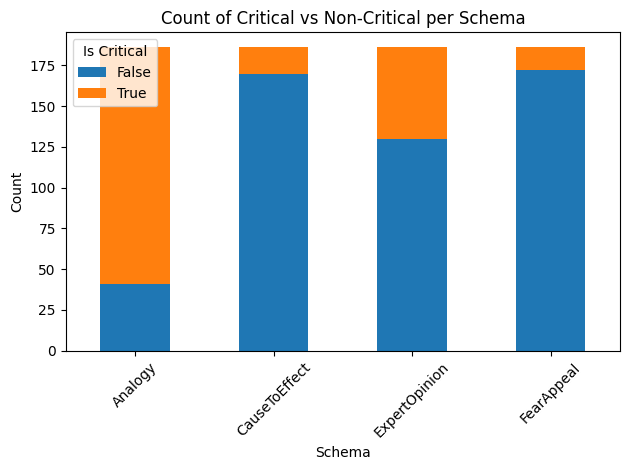

In [17]:
summary.plot(kind='bar', stacked=True)
plt.title('Count of Critical vs Non-Critical per Schema')
plt.xlabel('Schema')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Is Critical')
plt.tight_layout()
plt.show()

In [18]:
score_stats = df.groupby('schema')['score'].describe()
print(score_stats)


               count      mean       std  min  25%  50%  75%   max
schema                                                            
Analogy        186.0  7.395161  1.566034  3.0  7.0  7.0  8.0  10.0
CauseToEffect  186.0  3.760753  2.477033  1.0  1.0  3.0  6.0  10.0
ExpertOpinion  186.0  5.053763  2.778258  0.0  3.0  5.0  7.5  10.5
FearAppeal     186.0  3.768817  1.615899  2.0  3.0  3.0  5.0   8.0


In [19]:
median_scores = df.groupby('schema')['score'].median()
print("\nMedian scores per schema:")
print(median_scores)


Median scores per schema:
schema
Analogy          7.0
CauseToEffect    3.0
ExpertOpinion    5.0
FearAppeal       3.0
Name: score, dtype: float64


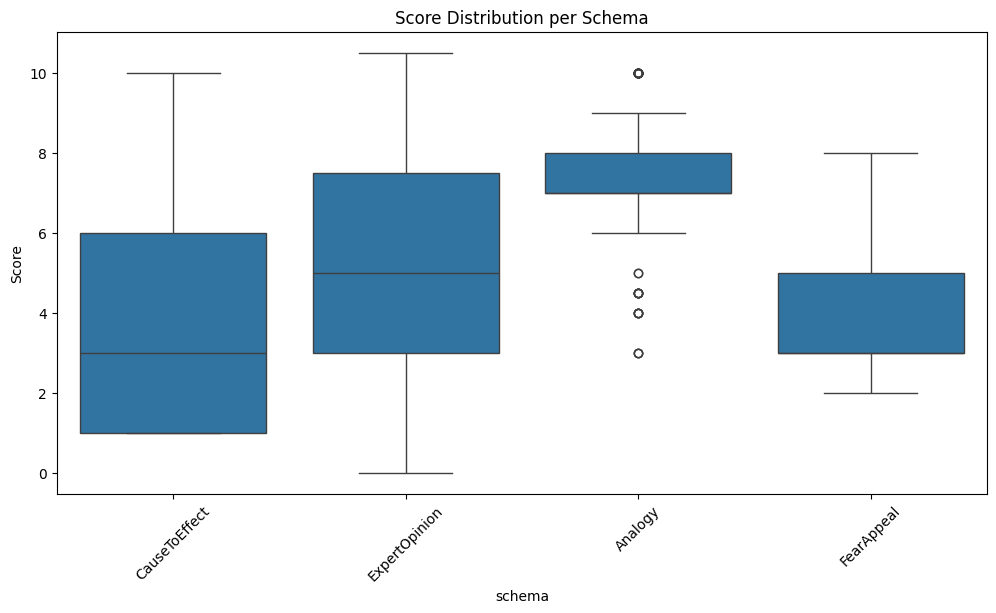

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='schema', y='score')
plt.title('Score Distribution per Schema')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.show()

Count of questions per schema by is_critical:
is_critical    False  True 
schema                     
Analogy           41    145
CauseToEffect    170     16
ExpertOpinion    130     56
FearAppeal       172     14


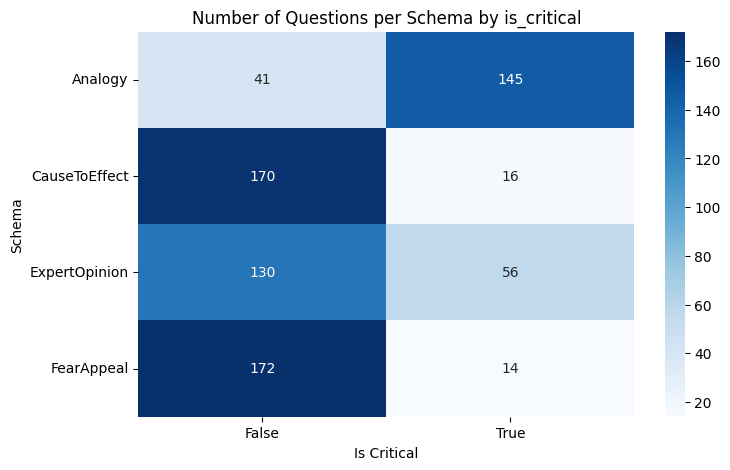

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

counts = pd.crosstab(df['schema'], df['is_critical'])

print("Count of questions per schema by is_critical:")
print(counts)

plt.figure(figsize=(8,5))
sns.heatmap(counts, annot=True, fmt='d', cmap='Blues')
plt.title('Number of Questions per Schema by is_critical')
plt.xlabel('Is Critical')
plt.ylabel('Schema')
plt.show()